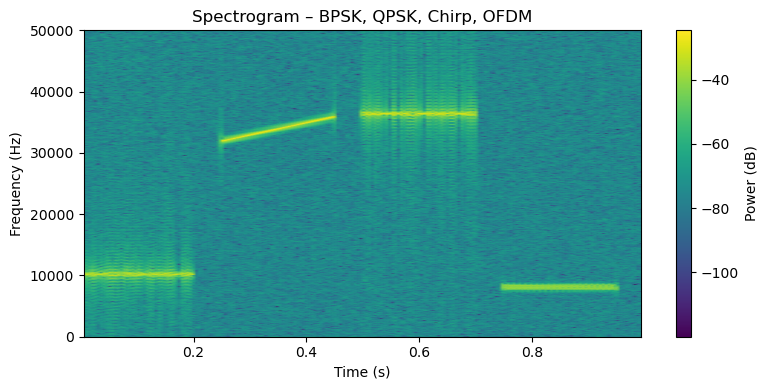

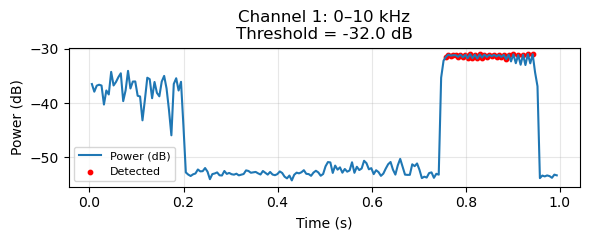

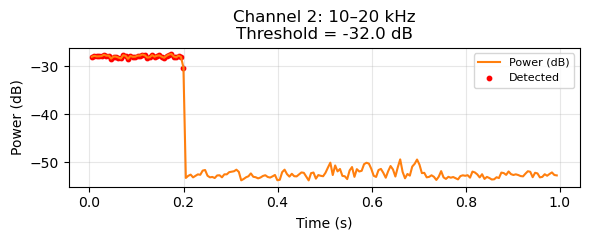

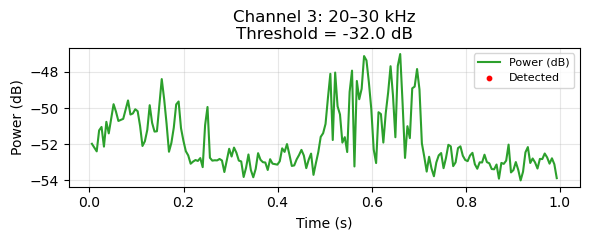

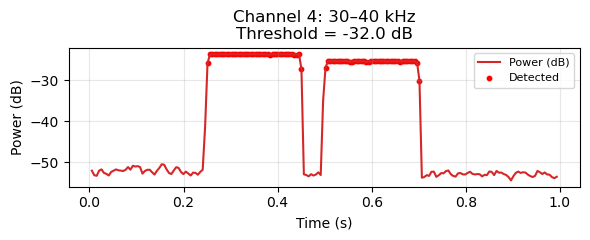

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# --------------------------------------------------------------------
# 1. Parameters
# --------------------------------------------------------------------
fs = 100_000           # 100 kHz sampling rate
duration = 1.0         # 1 second
t = np.arange(0, duration, 1 / fs)

# Waveform types
wave_types = ['bpsk', 'qpsk', 'chirp', 'ofdm']

# Random shuffle of waveforms, center frequencies, and amplitudes
rng = np.random.default_rng(seed=10)
center_freqs = rng.uniform(3_000, 38_000, size=4)
amplitudes = rng.uniform(0.3, 1.2, size=4)
order = rng.permutation(4)

slot_len = duration / 4
events = []

for idx, slot_id in enumerate(order):
    start = idx * slot_len
    end = start + slot_len * 0.8
    f0 = center_freqs[slot_id]
    amp = amplitudes[slot_id]
    wtype = wave_types[slot_id]
    events.append((start, end, f0, amp, wtype))

# --------------------------------------------------------------------
# 2. Build composite signal
# --------------------------------------------------------------------
x = np.zeros_like(t)

for start, end, f0, amp, wtype in events:
    idx_mask = (t >= start) & (t < end)
    tt = t[idx_mask] - start
    dur = end - start
    phase0 = 2 * np.pi * rng.random()

    if wtype == 'bpsk':
        sym_rate = 500
        sym_samp = int(fs / sym_rate)
        num_sym = int(np.ceil(tt.size / sym_samp))
        bits = rng.choice([-1, 1], size=num_sym)
        bpsk_seq = np.repeat(bits, sym_samp)[:tt.size]
        carrier = np.cos(2 * np.pi * f0 * tt + phase0)
        x[idx_mask] += amp * bpsk_seq * carrier

    elif wtype == 'qpsk':
        sym_rate = 500
        sym_samp = int(fs / sym_rate)
        num_sym = int(np.ceil(tt.size / sym_samp))
        bits_i = rng.choice([-1, 1], size=num_sym)
        bits_q = rng.choice([-1, 1], size=num_sym)
        qpsk_seq = bits_i + 1j * bits_q
        qpsk_seq = np.repeat(qpsk_seq, sym_samp)[:tt.size]
        carrier = np.exp(1j * (2 * np.pi * f0 * tt + phase0))
        x[idx_mask] += amp * np.real(qpsk_seq * carrier)

    elif wtype == 'chirp':
        k = 4000 / dur
        inst_phase = 2 * np.pi * (f0 * tt + 0.5 * k * tt ** 2)
        x[idx_mask] += amp * np.cos(inst_phase + phase0)

    elif wtype == 'ofdm':
        num_subcarriers = 8
        spacing = 100
        ofdm_sig = np.zeros_like(tt)
        for k_sub in range(num_subcarriers):
            fk = f0 + (k_sub - num_subcarriers // 2) * spacing
            ph = 2 * np.pi * rng.random()
            ofdm_sig += rng.choice([-1, 1]) * np.cos(2 * np.pi * fk * tt + ph)
        x[idx_mask] += amp * ofdm_sig / num_subcarriers

x += 0.05 * rng.normal(size=x.size)

# --------------------------------------------------------------------
# 3. Spectrogram (before channelizing)
# --------------------------------------------------------------------
nfft = 1024
noverlap = nfft // 2
freq_bins, time_bins, Sxx = spectrogram(
    x, fs=fs, nperseg=nfft, noverlap=noverlap
)

plt.figure(figsize=(8, 4))
plt.pcolormesh(
    time_bins,
    freq_bins,
    10 * np.log10(Sxx + 1e-12),
    shading='gouraud'
)
plt.title("Spectrogram – BPSK, QPSK, Chirp, OFDM")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 4. FFT-bin Channelizer (0–10, 10–20, 20–30, 30–40 kHz)
# --------------------------------------------------------------------
band_edges = np.array([0, 10_000, 20_000, 30_000, 40_000])
num_ch = len(band_edges) - 1

ch_power_db = []
ch_power_linear = []

for ch in range(num_ch):
    mask = (freq_bins >= band_edges[ch]) & (freq_bins < band_edges[ch + 1])
    pwr_lin = np.sum(Sxx[mask, :], axis=0)
    ch_power_linear.append(pwr_lin)
    ch_power_db.append(10 * np.log10(pwr_lin + 1e-12))

# --------------------------------------------------------------------
# 5. Energy Detection
# --------------------------------------------------------------------
thresholds = []
detection_flags = []

# 수동 dB 임계치
thresholds_db = [-32.0, -32.0, -32.0, -32.0]

for ch in range(num_ch):
    thresh_db = thresholds_db[ch]
    thresh_lin = 10 ** (thresh_db / 10)
    thresholds.append(thresh_lin)

    det_flag = ch_power_linear[ch] > thresh_lin
    detection_flags.append(det_flag)

# --------------------------------------------------------------------
# 6. Plot Results
# --------------------------------------------------------------------
for i in range(num_ch):
    plt.figure(figsize=(6, 2.5))
    plt.plot(time_bins, ch_power_db[i], color=f'C{i}', label="Power (dB)")

    det_times = time_bins[detection_flags[i]]
    det_pwr_db = ch_power_db[i][detection_flags[i]]
    plt.scatter(
        det_times,
        det_pwr_db,
        color='red',
        s=10,
        marker='o',
        label="Detected"
    )

    plt.xlabel("Time (s)")
    plt.ylabel("Power (dB)")
    plt.title(
        f"Channel {i+1}: {band_edges[i]/1e3:.0f}–{band_edges[i+1]/1e3:.0f} kHz\n"
        f"Threshold = {thresholds_db[i]} dB"
    )
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()


In [20]:
print("\n=== Waveform Slot Assignment ===")
for i, (start, end, f0, amp, wtype) in enumerate(events):
    print(f"Slot {i+1}: {wtype.upper():<5} | {start:.2f}s–{end:.2f}s | "
          f"f0 = {f0/1e3:.1f} kHz | amp = {amp:.2f}")

print("\n=== Signal → Channel Mapping ===")
for i, (start, end, f0, amp, wtype) in enumerate(events):
    # 채널 결정
    ch_idx = np.searchsorted(band_edges, f0, side='right') - 1
    ch_range = f"{band_edges[ch_idx]/1e3:.0f}–{band_edges[ch_idx+1]/1e3:.0f} kHz"
    print(f"{wtype.upper():<5} in Slot {i+1}: f0 = {f0/1e3:.2f} kHz → Channel {ch_idx+1} ({ch_range})")

print("\n")
print(x.shape)
print(freq_bins.shape)
print(time_bins.shape)
print(Sxx.shape)


=== Waveform Slot Assignment ===
Slot 1: QPSK  | 0.00s–0.20s | f0 = 10.3 kHz | amp = 0.42
Slot 2: CHIRP | 0.25s–0.45s | f0 = 32.0 kHz | amp = 0.92
Slot 3: BPSK  | 0.50s–0.70s | f0 = 36.5 kHz | amp = 0.76
Slot 4: OFDM  | 0.75s–0.95s | f0 = 8.2 kHz | amp = 1.06

=== Signal → Channel Mapping ===
QPSK  in Slot 1: f0 = 10.27 kHz → Channel 2 (10–20 kHz)
CHIRP in Slot 2: f0 = 32.00 kHz → Channel 4 (30–40 kHz)
BPSK  in Slot 3: f0 = 36.46 kHz → Channel 4 (30–40 kHz)
OFDM  in Slot 4: f0 = 8.22 kHz → Channel 1 (0–10 kHz)


(100000,)
(513,)
(194,)
(513, 194)


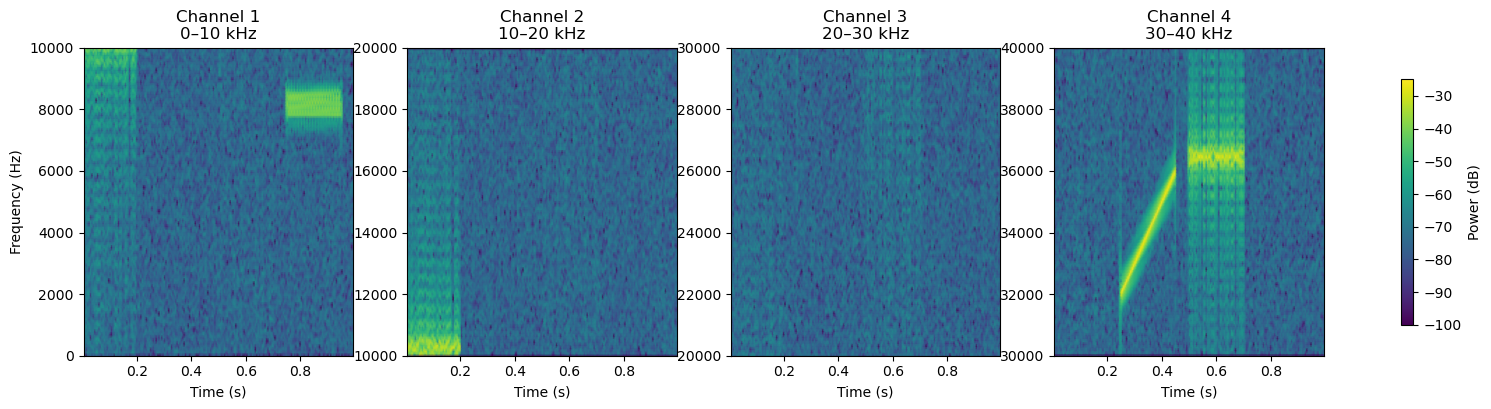

In [21]:
# band_edges와 채널 수 정의
band_edges = np.array([0, 10_000, 20_000, 30_000, 40_000])
num_ch = len(band_edges) - 1

# subplot 생성
plt.figure(figsize=(5 * num_ch, 4))

for i in range(num_ch):
    lower, upper = band_edges[i], band_edges[i + 1]
    mask = (freq_bins >= lower) & (freq_bins < upper)

    # 채널별로 마스킹된 스펙트럼 생성
    Sxx_masked = np.full_like(Sxx, 1e-12)
    Sxx_masked[mask, :] = Sxx[mask, :]

    # subplot 위치 지정
    plt.subplot(1, num_ch, i + 1)

    # pcolormesh 실행
    pcm = plt.pcolormesh(
        time_bins,
        freq_bins,
        10 * np.log10(Sxx_masked + 1e-12),
        shading='gouraud',
        vmin=-100,
        vmax=np.max(10 * np.log10(Sxx + 1e-12)),
    )

    plt.ylim(lower, upper)
    plt.title(f"Channel {i+1}\n{lower/1e3:.0f}–{upper/1e3:.0f} kHz")
    plt.xlabel("Time (s)")
    if i == 0:
        plt.ylabel("Frequency (Hz)")


# 하나의 공통 colorbar 추가
cbar = plt.colorbar(pcm, ax=plt.gcf().get_axes(), orientation='vertical', shrink=0.8)
cbar.set_label("Power (dB)")


plt.show()

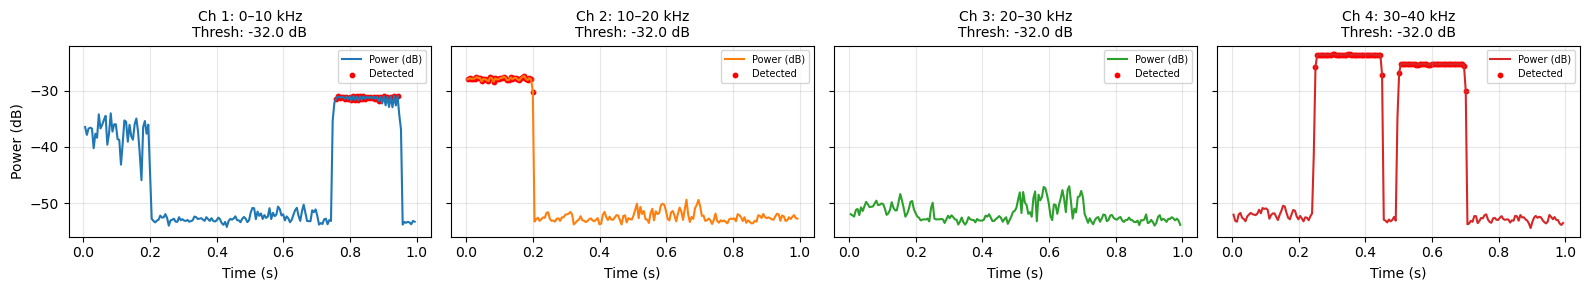

In [22]:
# --------------------------------------------------------------------
# 6. Plot Results (subplot version: 1 row × 4 columns)
# --------------------------------------------------------------------
fig, axes = plt.subplots(1, num_ch, figsize=(16, 3), sharey=True)

for i in range(num_ch):
    ax = axes[i]
    ax.plot(time_bins, ch_power_db[i], color=f'C{i}', label="Power (dB)")

    det_times = time_bins[detection_flags[i]]
    det_pwr_db = ch_power_db[i][detection_flags[i]]
    ax.scatter(
        det_times,
        det_pwr_db,
        color='red',
        s=10,
        marker='o',
        label="Detected"
    )

    ax.set_title(
        f"Ch {i+1}: {band_edges[i]/1e3:.0f}–{band_edges[i+1]/1e3:.0f} kHz\n"
        f"Thresh: {thresholds_db[i]} dB",
        fontsize=10
    )
    ax.set_xlabel("Time (s)")
    if i == 0:
        ax.set_ylabel("Power (dB)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7, loc="best")

plt.tight_layout()
plt.show()
